# Hyperparamter optimization using optuna

In [1]:
import numpy as np

import optuna

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: tf.config.experimental.set_memory_growth(gpus[0], True)

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Simple Practice
### objective function

$$
f(x) = 2x^4 - 5x^2 + x
$$

We will find the minimum value of $f(x^*)$ and $x^*$ using optuna which is provided Prefferd Networks.

### graph of $f(x)$

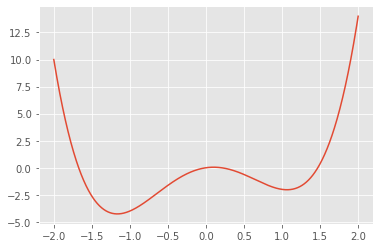

In [2]:
x = np.linspace(-2, 2, 1000)
plt.plot(x, 2*x**4 - 5*x**2 + x)

### optimization
We will minimize $f(x)$ where $x \in [-2, 2]$.

In [3]:
def objective(trial):
    x = trial.suggest_uniform('x', -2, 2)
    return 2*x**4 - 5*x**2 + x

In [4]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

[I 2019-10-13 15:27:12,097] Finished trial#0 resulted in value: -0.5258474403841071. Current best value is -0.5258474403841071 with parameters: {'x': 0.4661336123543931}.
[I 2019-10-13 15:27:12,151] Finished trial#1 resulted in value: -2.4886603544596833. Current best value is -2.4886603544596833 with parameters: {'x': -0.6656911748325132}.
[I 2019-10-13 15:27:12,199] Finished trial#2 resulted in value: 1.4174971759185562. Current best value is -2.4886603544596833 with parameters: {'x': -0.6656911748325132}.
[I 2019-10-13 15:27:12,244] Finished trial#3 resulted in value: 4.627948669344461. Current best value is -2.4886603544596833 with parameters: {'x': -0.6656911748325132}.
[I 2019-10-13 15:27:12,291] Finished trial#4 resulted in value: 9.003489682219643. Current best value is -2.4886603544596833 with parameters: {'x': -0.6656911748325132}.
[I 2019-10-13 15:27:12,338] Finished trial#5 resulted in value: 9.30721953821073. Current best value is -2.4886603544596833 with parameters: {'x':

### result

minimum f(x) :  -4.264953219641189
argmin f(x) :  {'x': -1.1784394834403784}


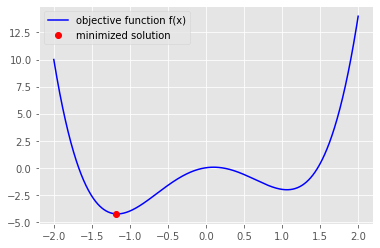

In [5]:
print("minimum f(x) : ", study.best_value)
print("argmin f(x) : ", study.best_params)

plt.plot(x, 2*x**4 - 5*x**2 + x, "b")
plt.plot(study.best_params['x'], study.best_value, "ro")
plt.legend(["objective function f(x)", "minimized solution"])

## optuna for TensorFlow Eager
### Create model
In this section, create_model funtion have an arg `trial` which is represente search spaces of 'num of layers' and 'dropout_rate'.  

In [6]:
def create_model(trial):
    # num of hidden layer
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    # dropout_rate
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    
    layers = []
    for i in range(n_layers):
        layers.append(
            tf.keras.layers.Conv2D(filters=(i+1)*16, 
                                   kernel_size=3, 
                                   padding="same",
                                   activation="relu")
        )
        layers.append(
            tf.keras.layers.MaxPool2D(pool_size=2, padding="same")
        )
        layers.append(
            tf.keras.layers.Dropout(rate=dropout_rate)
        )
    
    layers.append(tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(128, activation="relu"))
    layers.append(tf.keras.layers.Dense(10, activation="softmax"))
    
    return tf.keras.Sequential(layers)

### create optimizer
Then, we create optimzier.

In [7]:
def create_optimizer(trial):
    # Loguniform parameter
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    return optimizer

### create trainer
In this section we will create trainer which is simply training loop. We will use keras training API. 

In [8]:
def trainer(trial, x_train, y_train):
    
    batch_size=trial.suggest_categorical('batch_size', [256, 512, 1024])
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    model.fit(x=x_train,
              y=y_train,
              batch_size=batch_size,
              epochs=5,
              )
    
    model.fit = tf.function(model.fit)

    return model

#### objective
We create objective function. Note that optuna minimize objective function, so when we create objective function, this is defined "better equal to smaller". Therefore, we define objective function "`1 - accuracy`".

In [9]:
def objective(trial):
    
    (x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    x_train_ = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train_ = tf.reshape(tf.one_hot(y_train, 10), (-1, 10))
    x_test_ = tf.convert_to_tensor(x_test, dtype=tf.float32)
    y_test_ = tf.reshape(tf.one_hot(y_test, 10), (-1, 10))


    model = trainer(trial, x_train_, y_train_)
    
    evaluate = model.evaluate(x=x_test_, y=y_test_, verbose=False)
    return 1 - evaluate[1]

In [10]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 3:11 - loss: 2.3196 - accuracy: 0.09 - ETA: 46s - loss: 2.2298 - accuracy: 0.2034 - ETA: 25s - loss: 2.0834 - accuracy: 0.328 - ETA: 16s - loss: 1.8722 - accuracy: 0.410 - ETA: 11s - loss: 1.6436 - accuracy: 0.476 - ETA: 8s - loss: 1.5115 - accuracy: 0.515 - ETA: 6s - loss: 1.3591 - accuracy: 0.56 - ETA: 5s - loss: 1.2438 - accuracy: 0.59 - ETA: 4s - loss: 1.1704 - accuracy: 0.62 - ETA: 3s - loss: 1.0815 - accuracy: 0.65 - ETA: 2s - loss: 1.0249 - accuracy: 0.67 - ETA: 2s - loss: 0.9738 - accuracy: 0.68 - ETA: 1s - loss: 0.9275 - accuracy: 0.70 - ETA: 1s - loss: 0.8746 - accuracy: 0.72 - ETA: 0s - loss: 0.8280 - accuracy: 0.73 - ETA: 0s - loss: 0.7960 - accuracy: 0.74 - ETA: 0s - loss: 0.7672 - accuracy: 0.75 - 4s 74us/sample - loss: 0.7344 - accuracy: 0.7654
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.93 - ETA: 0s - loss: 0.2197 - accuracy: 0.93 - ETA:

[I 2019-10-13 15:27:24,206] Finished trial#0 resulted in value: 0.01380002498626709. Current best value is 0.01380002498626709 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.1879993798088161, 'learning_rate': 0.0022191905172051674}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 39s - loss: 2.3252 - accuracy: 0.068 - ETA: 4s - loss: 2.0673 - accuracy: 0.415 - ETA: 2s - loss: 1.7977 - accuracy: 0.54 - ETA: 1s - loss: 1.5492 - accuracy: 0.62 - ETA: 1s - loss: 1.3453 - accuracy: 0.67 - ETA: 0s - loss: 1.1935 - accuracy: 0.70 - ETA: 0s - loss: 1.0758 - accuracy: 0.73 - ETA: 0s - loss: 0.9844 - accuracy: 0.75 - ETA: 0s - loss: 0.9113 - accuracy: 0.76 - ETA: 0s - loss: 0.8509 - accuracy: 0.78 - ETA: 0s - loss: 0.8010 - accuracy: 0.79 - ETA: 0s - loss: 0.7587 - accuracy: 0.80 - ETA: 0s - loss: 0.7208 - accuracy: 0.81 - 1s 18us/sample - loss: 0.6892 - accuracy: 0.8221
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.92 - ETA: 0s - loss: 0.2750 - accuracy: 0.92 - ETA: 0s - loss: 0.2694 - accuracy: 0.92 - ETA: 0s - loss: 0.2681 - accuracy: 0.92 - ETA: 0s - loss: 0.2667 - accuracy: 0.92 - ETA: 0s - loss: 0.2653 - accuracy: 0.92 - ETA: 0s - los

[I 2019-10-13 15:27:29,482] Finished trial#1 resulted in value: 0.025699973106384277. Current best value is 0.01380002498626709 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.1879993798088161, 'learning_rate': 0.0022191905172051674}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 23s - loss: 2.3276 - accuracy: 0.109 - ETA: 5s - loss: 2.2174 - accuracy: 0.227 - ETA: 3s - loss: 2.0420 - accuracy: 0.31 - ETA: 2s - loss: 1.8414 - accuracy: 0.37 - ETA: 1s - loss: 1.6859 - accuracy: 0.42 - ETA: 1s - loss: 1.5521 - accuracy: 0.47 - ETA: 1s - loss: 1.4123 - accuracy: 0.52 - ETA: 1s - loss: 1.2884 - accuracy: 0.56 - ETA: 0s - loss: 1.1835 - accuracy: 0.60 - ETA: 0s - loss: 1.0960 - accuracy: 0.63 - ETA: 0s - loss: 1.0196 - accuracy: 0.66 - ETA: 0s - loss: 0.9713 - accuracy: 0.67 - ETA: 0s - loss: 0.9297 - accuracy: 0.69 - ETA: 0s - loss: 0.8900 - accuracy: 0.70 - ETA: 0s - loss: 0.8544 - accuracy: 0.71 - ETA: 0s - loss: 0.8136 - accuracy: 0.73 - ETA: 0s - loss: 0.7857 - accuracy: 0.74 - 1s 22us/sample - loss: 0.7623 - accuracy: 0.7481
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.90 - ETA: 0s - loss: 0.2618 - accuracy: 0.91 - ETA: 0s - los

[I 2019-10-13 15:27:36,003] Finished trial#2 resulted in value: 0.013000011444091797. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 16s - loss: 2.2942 - accuracy: 0.137 - ETA: 2s - loss: 2.2504 - accuracy: 0.241 - ETA: 1s - loss: 2.2113 - accuracy: 0.31 - ETA: 0s - loss: 2.1700 - accuracy: 0.37 - ETA: 0s - loss: 2.1292 - accuracy: 0.42 - ETA: 0s - loss: 2.0931 - accuracy: 0.45 - ETA: 0s - loss: 2.0557 - accuracy: 0.48 - ETA: 0s - loss: 2.0081 - accuracy: 0.51 - ETA: 0s - loss: 1.9627 - accuracy: 0.54 - ETA: 0s - loss: 1.9148 - accuracy: 0.56 - 1s 14us/sample - loss: 1.8707 - accuracy: 0.5875
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 1.4149 - accuracy: 0.78 - ETA: 0s - loss: 1.3420 - accuracy: 0.79 - ETA: 0s - loss: 1.2998 - accuracy: 0.79 - ETA: 0s - loss: 1.2609 - accuracy: 0.79 - ETA: 0s - loss: 1.2223 - accuracy: 0.80 - ETA: 0s - loss: 1.1863 - accuracy: 0.80 - ETA: 0s - loss: 1.1496 - accuracy: 0.80 - ETA: 0s - loss: 1.1182 - accuracy: 0.81 - ETA: 0s - loss: 1.0812 - accuracy: 0.81 - ETA: 0s - los

[I 2019-10-13 15:27:40,296] Finished trial#3 resulted in value: 0.08840000629425049. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 33s - loss: 2.3157 - accuracy: 0.119 - ETA: 3s - loss: 1.6917 - accuracy: 0.601 - ETA: 2s - loss: 1.2293 - accuracy: 0.70 - ETA: 1s - loss: 0.9820 - accuracy: 0.75 - ETA: 1s - loss: 0.8385 - accuracy: 0.78 - ETA: 0s - loss: 0.7396 - accuracy: 0.81 - ETA: 0s - loss: 0.6689 - accuracy: 0.82 - ETA: 0s - loss: 0.6109 - accuracy: 0.83 - ETA: 0s - loss: 0.5733 - accuracy: 0.84 - ETA: 0s - loss: 0.5423 - accuracy: 0.85 - ETA: 0s - loss: 0.5142 - accuracy: 0.86 - ETA: 0s - loss: 0.4890 - accuracy: 0.86 - ETA: 0s - loss: 0.4682 - accuracy: 0.87 - 1s 16us/sample - loss: 0.4520 - accuracy: 0.8774
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.91 - ETA: 0s - loss: 0.2072 - accuracy: 0.93 - ETA: 0s - loss: 0.1974 - accuracy: 0.93 - ETA: 0s - loss: 0.1880 - accuracy: 0.94 - ETA: 0s - loss: 0.1829 - accuracy: 0.94 - ETA: 0s - loss: 0.1801 - accuracy: 0.94 - ETA: 0s - los

[I 2019-10-13 15:27:45,406] Finished trial#4 resulted in value: 0.018999993801116943. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 46s - loss: 2.2983 - accuracy: 0.089 - ETA: 7s - loss: 1.5945 - accuracy: 0.506 - ETA: 4s - loss: 1.1415 - accuracy: 0.64 - ETA: 2s - loss: 0.9078 - accuracy: 0.72 - ETA: 2s - loss: 0.7593 - accuracy: 0.76 - ETA: 1s - loss: 0.6606 - accuracy: 0.79 - ETA: 1s - loss: 0.5915 - accuracy: 0.82 - ETA: 1s - loss: 0.5363 - accuracy: 0.83 - ETA: 0s - loss: 0.4914 - accuracy: 0.85 - ETA: 0s - loss: 0.4528 - accuracy: 0.86 - ETA: 0s - loss: 0.4223 - accuracy: 0.87 - ETA: 0s - loss: 0.3976 - accuracy: 0.87 - ETA: 0s - loss: 0.3746 - accuracy: 0.88 - ETA: 0s - loss: 0.3547 - accuracy: 0.89 - ETA: 0s - loss: 0.3372 - accuracy: 0.89 - ETA: 0s - loss: 0.3225 - accuracy: 0.90 - ETA: 0s - loss: 0.3065 - accuracy: 0.90 - 1s 23us/sample - loss: 0.2965 - accuracy: 0.9112
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - los

[I 2019-10-13 15:27:51,857] Finished trial#5 resulted in value: 0.01380002498626709. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 1:44 - loss: 2.3118 - accuracy: 0.10 - ETA: 10s - loss: 2.2114 - accuracy: 0.2745 - ETA: 5s - loss: 2.1077 - accuracy: 0.390 - ETA: 4s - loss: 1.9483 - accuracy: 0.49 - ETA: 3s - loss: 1.7716 - accuracy: 0.56 - ETA: 2s - loss: 1.6164 - accuracy: 0.60 - ETA: 2s - loss: 1.4773 - accuracy: 0.63 - ETA: 1s - loss: 1.3371 - accuracy: 0.66 - ETA: 1s - loss: 1.2369 - accuracy: 0.68 - ETA: 1s - loss: 1.1437 - accuracy: 0.70 - ETA: 1s - loss: 1.0651 - accuracy: 0.72 - ETA: 1s - loss: 1.0070 - accuracy: 0.73 - ETA: 1s - loss: 0.9565 - accuracy: 0.75 - ETA: 0s - loss: 0.9127 - accuracy: 0.76 - ETA: 0s - loss: 0.8758 - accuracy: 0.76 - ETA: 0s - loss: 0.8384 - accuracy: 0.77 - ETA: 0s - loss: 0.8064 - accuracy: 0.78 - ETA: 0s - loss: 0.7769 - accuracy: 0.79 - ETA: 0s - loss: 0.7507 - accuracy: 0.80 - ETA: 0s - loss: 0.7282 - accuracy: 0.80 - ETA: 0s - loss: 0.7024 - accuracy: 0.81 - ETA: 0s - loss: 0.6825 - accurac

[I 2019-10-13 15:27:59,868] Finished trial#6 resulted in value: 0.016200006008148193. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 24s - loss: 2.3199 - accuracy: 0.116 - ETA: 5s - loss: 2.3103 - accuracy: 0.112 - ETA: 3s - loss: 2.3063 - accuracy: 0.11 - ETA: 2s - loss: 2.3017 - accuracy: 0.11 - ETA: 1s - loss: 2.2984 - accuracy: 0.11 - ETA: 1s - loss: 2.2947 - accuracy: 0.12 - ETA: 1s - loss: 2.2921 - accuracy: 0.12 - ETA: 0s - loss: 2.2886 - accuracy: 0.12 - ETA: 0s - loss: 2.2850 - accuracy: 0.13 - ETA: 0s - loss: 2.2823 - accuracy: 0.13 - ETA: 0s - loss: 2.2781 - accuracy: 0.14 - ETA: 0s - loss: 2.2741 - accuracy: 0.14 - ETA: 0s - loss: 2.2695 - accuracy: 0.15 - ETA: 0s - loss: 2.2643 - accuracy: 0.16 - ETA: 0s - loss: 2.2592 - accuracy: 0.17 - 1s 22us/sample - loss: 2.2541 - accuracy: 0.1779
Epoch 2/5
60000/60000 [==============================] - ETA: 1s - loss: 2.1600 - accuracy: 0.32 - ETA: 0s - loss: 2.1522 - accuracy: 0.31 - ETA: 0s - loss: 2.1415 - accuracy: 0.33 - ETA: 0s - loss: 2.1294 - accuracy: 0.35 - ETA: 0s - los

[I 2019-10-13 15:28:06,373] Finished trial#7 resulted in value: 0.11059999465942383. Current best value is 0.013000011444091797 with parameters: {'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.40068870699534304, 'learning_rate': 0.0034296908468772207}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 1:42 - loss: 2.3069 - accuracy: 0.08 - ETA: 12s - loss: 2.1459 - accuracy: 0.2439 - ETA: 6s - loss: 1.7661 - accuracy: 0.392 - ETA: 4s - loss: 1.4758 - accuracy: 0.49 - ETA: 3s - loss: 1.2644 - accuracy: 0.57 - ETA: 3s - loss: 1.1047 - accuracy: 0.62 - ETA: 2s - loss: 0.9727 - accuracy: 0.67 - ETA: 2s - loss: 0.8690 - accuracy: 0.70 - ETA: 2s - loss: 0.7919 - accuracy: 0.73 - ETA: 1s - loss: 0.7259 - accuracy: 0.75 - ETA: 1s - loss: 0.6745 - accuracy: 0.77 - ETA: 1s - loss: 0.6287 - accuracy: 0.79 - ETA: 1s - loss: 0.5889 - accuracy: 0.80 - ETA: 1s - loss: 0.5588 - accuracy: 0.81 - ETA: 1s - loss: 0.5316 - accuracy: 0.82 - ETA: 0s - loss: 0.5052 - accuracy: 0.83 - ETA: 0s - loss: 0.4822 - accuracy: 0.84 - ETA: 0s - loss: 0.4614 - accuracy: 0.84 - ETA: 0s - loss: 0.4438 - accuracy: 0.85 - ETA: 0s - loss: 0.4286 - accuracy: 0.85 - ETA: 0s - loss: 0.4133 - accuracy: 0.86 - ETA: 0s - loss: 0.4011 - accurac

[I 2019-10-13 15:28:15,098] Finished trial#8 resulted in value: 0.012199997901916504. Current best value is 0.012199997901916504 with parameters: {'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.1719969811887624, 'learning_rate': 0.002161035983226034}.


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 16s - loss: 2.3069 - accuracy: 0.101 - ETA: 2s - loss: 2.2017 - accuracy: 0.266 - ETA: 1s - loss: 2.0890 - accuracy: 0.41 - ETA: 0s - loss: 1.9700 - accuracy: 0.50 - ETA: 0s - loss: 1.8499 - accuracy: 0.56 - ETA: 0s - loss: 1.7374 - accuracy: 0.60 - ETA: 0s - loss: 1.6290 - accuracy: 0.63 - ETA: 0s - loss: 1.5308 - accuracy: 0.66 - ETA: 0s - loss: 1.4408 - accuracy: 0.68 - ETA: 0s - loss: 1.3597 - accuracy: 0.70 - 1s 13us/sample - loss: 1.3165 - accuracy: 0.7106
Epoch 2/5
60000/60000 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.83 - ETA: 0s - loss: 0.6148 - accuracy: 0.84 - ETA: 0s - loss: 0.5808 - accuracy: 0.85 - ETA: 0s - loss: 0.5615 - accuracy: 0.85 - ETA: 0s - loss: 0.5425 - accuracy: 0.86 - ETA: 0s - loss: 0.5280 - accuracy: 0.86 - ETA: 0s - loss: 0.5151 - accuracy: 0.86 - ETA: 0s - loss: 0.5011 - accuracy: 0.87 - ETA: 0s - loss: 0.4906 - accuracy: 0.87 - ETA: 0s - los

[I 2019-10-13 15:28:19,324] Finished trial#9 resulted in value: 0.0625. Current best value is 0.012199997901916504 with parameters: {'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.1719969811887624, 'learning_rate': 0.002161035983226034}.


In [11]:
study.trials

[FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, value=0.01380002498626709, datetime_start=datetime.datetime(2019, 10, 13, 15, 27, 13, 748241), datetime_complete=datetime.datetime(2019, 10, 13, 15, 27, 24, 206991), params={'batch_size': 1024, 'n_layers': 3, 'dropout_rate': 0.1879993798088161, 'learning_rate': 0.0022191905172051674}, distributions={'batch_size': CategoricalDistribution(choices=(256, 512, 1024)), 'n_layers': IntUniformDistribution(low=1, high=3), 'dropout_rate': UniformDistribution(low=0.0, high=0.5), 'learning_rate': LogUniformDistribution(low=1e-05, high=0.01)}, user_attrs={}, system_attrs={'_number': 0}, intermediate_values={}, trial_id=0),
 FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, value=0.025699973106384277, datetime_start=datetime.datetime(2019, 10, 13, 15, 27, 24, 208967), datetime_complete=datetime.datetime(2019, 10, 13, 15, 27, 29, 482984), params={'batch_size': 512, 'n_layers': 1, 'dropout_rate': 0.3730097986935437, 'learning_rate': 0.00049523

In [12]:
print("best params: ", study.best_params)
print("best test accuracy: ", 1 - study.best_value)

best params:  {'batch_size': 256, 'n_layers': 3, 'dropout_rate': 0.1719969811887624, 'learning_rate': 0.002161035983226034}
best test accuracy:  0.9878000020980835
